In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn

We'll use a 3D grid tensor network as our basic example.

In [2]:
Lx = Ly = Lz = 4
D = 2
tn = qtn.TN3D_rand(Lx, Ly, Lz, D=D)

By default bonds are draw proportional to ``log2`` of their dimension, whereas nodes are fixed in size.

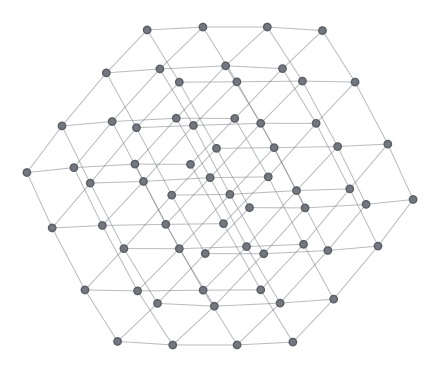

In [3]:
tn.draw()

By default index names are not shown and tensor tags are only shown for small tensors, these can both be controlled manually like so:

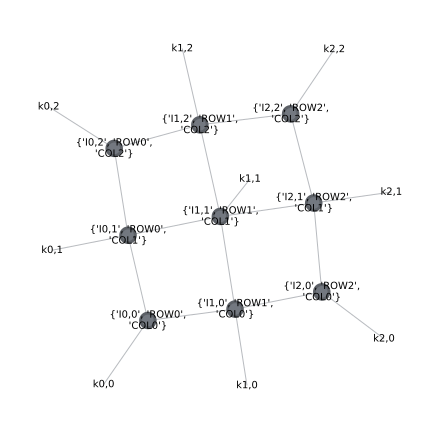

In [4]:
qtn.PEPS.rand(3, 3, D).draw(show_tags=True, show_inds=True)

If you want to see inner index names (bonds) as well as the outer index names you need to use ``show_inds='all'``:

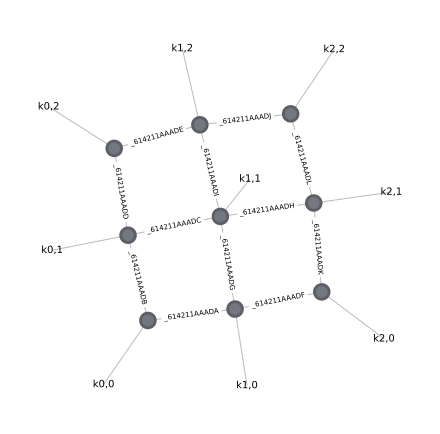

In [5]:
qtn.PEPS.rand(3, 3, D).draw(show_tags=False, show_inds='all')

# Coloring

The first argument to ``draw`` is ``color=``, which can either be a single tag or a sequence of tags. All tensors with each tag will be colored the same, with later tags taking priority:

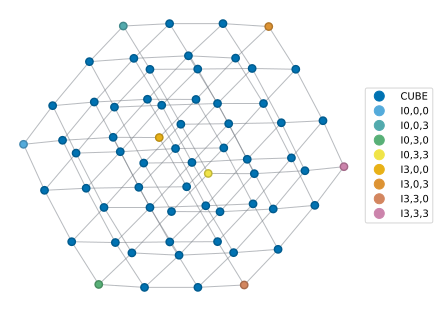

In [6]:
# add the same tag to every tensor
tn.add_tag('CUBE')

# color that tag and each corner of our TN
color = ['CUBE'] + [
    f'I{i},{j},{k}' 
    for i in (0, Lx - 1) 
    for j in (0, Ly - 1) 
    for k in (0, Lz - 1)
]

tn.draw(color=color)

If you have many tags or are simply only interested in the drawing the colors you can supply the ``legend=False`` option to turn off the legend. 

# Highlighting indices 

You can visualize a subset of indices by supplying a sequence of them to the ``highlight_inds=`` kwarg like so:

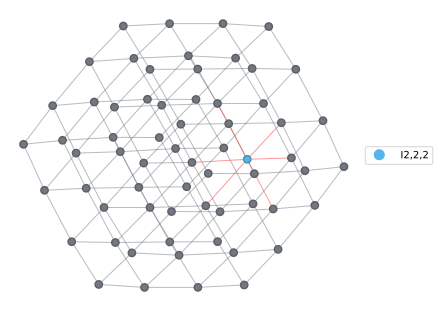

In [7]:
# get a central tensor and its indices
tag = f"I{Lx // 2},{Ly // 2},{Lz // 2}"
t = tn[tag]
inds = t.inds
tn.draw(color=tag, highlight_inds=inds)

The color can be controlled with ``highlight_inds_color``.

# Highlighting ``tids``

While tensors can carry arbitrary tags and can usually be identified by these, it is sometimes useful to be able to highlight tensors based on their underlying ``tids`` - each of which is a unique integer representing a node in the hypergraph.

In [8]:
# get the first plane of tensor tids
tids = list(tn.tensor_map.keys())[:Lx * Ly]
tids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

The color can be controlled with ``highlight_tids_color``:

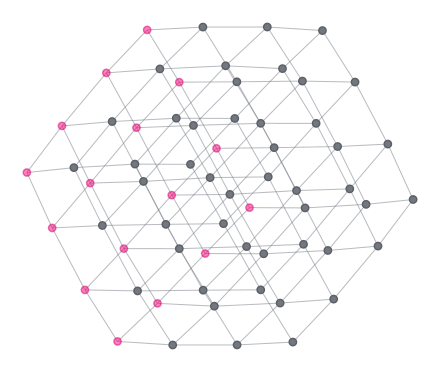

In [9]:
tn.draw(highlight_tids=tids, highlight_tids_color=(1.0, 0.0, 0.5, 0.5))

# Positioning tensors

## Automatic layouts

The automatic layout strategy `quimb` adopts is to lay the tensors out using some relatively efficient scheme, before 'relaxing' the positions using a (slower) force repulsion algorithm into something usually more natural.

The ``iterations`` kwarg controls the number of force repulsion steps, set this to zero to use only the initial layout algorithm (the default of which is ``'spectral'``):

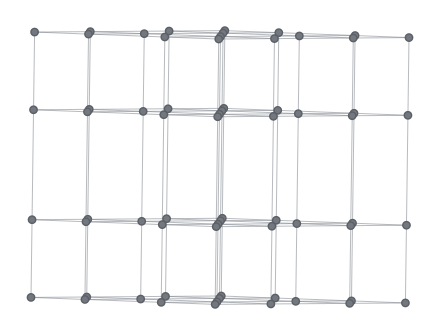

In [10]:
tn.draw(iterations=0)

Another good choice for the initial layout that you might try if ``'spectral'`` isn't producing good results is ``'kamada_kawai'``:

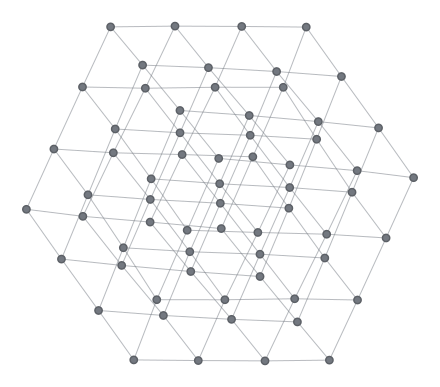

In [11]:
tn.draw(iterations=0, initial_layout='kamada_kawai')

You should be able to specify most of the [networkx layout algorithms](https://networkx.org/documentation/stable//reference/drawing.html#module-networkx.drawing.layout):

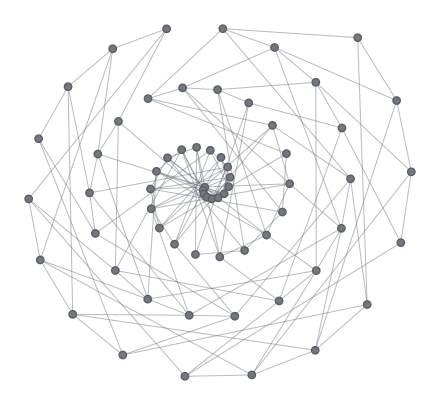

In [12]:
tn.draw(iterations=0, initial_layout='spiral')

## Force Repulsion options

For the [force repulsion layout](https://networkx.org/documentation/stable//reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout),
you can supply the spring constant ``k``, which can have a significant effect on the layout:

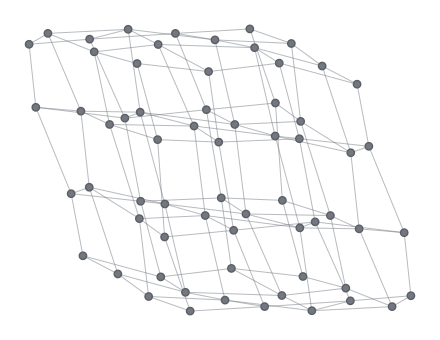

In [13]:
tn.draw(iterations=100, k=0.01)

You can also fix specific tensors (by either a ``tid`` or set of tags that uniquely identifies that tensor):

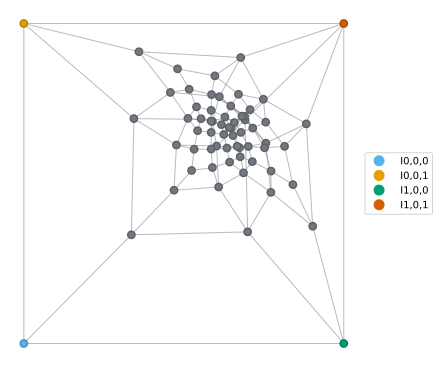

In [14]:
fix = {
    'I0,0,0': (0, 0),
    'I0,0,1': (0, 1),
    'I1,0,0': (1, 0),
    'I1,0,1': (1, 1),
}

# when fixing tensors you often have to play with ``k``
tn.draw(k=0.001, fix=fix, color=fix.keys())

If you have [``forceatlas2`` (``fa2``) ](https://github.com/bhargavchippada/forceatlas2) installed then you can specify to use it rather than the slower networkx force repulsion algorithm at a certain threshold of nodes (by default 1000) with the option ``use_forceatlas2=1000``.

## Manually Specifying

You can also simply specify all positions manually using the ``fix`` kwarg. Here's that illustrated with a axonometric projection:

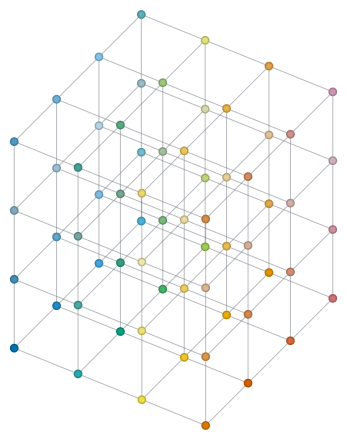

In [15]:
import math
import itertools

def get_3d_pos(i, j, k, a=22, b=45, p=0.2):
    return (
        + i * math.cos(math.pi * a / 180) + j * math.cos(math.pi * b / 180) / 2**p,
        - i * math.sin(math.pi * a / 180) + j * math.sin(math.pi * b / 180) / 2**p + k       
    )

pos = {
    f'I{i},{j},{k}': get_3d_pos(i, j, k)
    for i in range(Lx)
    for j in range(Ly)
    for k in range(Lz)
}


tn.draw(fix=pos, color=pos.keys(), legend=False)

If you want to retrieve an automatic positioning, e.g. for repeated use in an animation, you can pass the ``get='pos'`` option, which simply returns the positions as a dict mapping each ``tid`` to a 2D coordinate:

In [16]:
pos = tn.draw(get='pos')
pos[0], pos[1], pos[2]

(array([-1.00139021,  0.06992426]),
 array([-0.81934865,  0.31153009]),
 array([-0.58950712,  0.58652939]))

# Hyper-edges

Hyper edges (indices which appear on 3 or more tensors) are represented as separate 'nodes' of zero size - since they are equivalent to placing a multi-dimensional COPY-tensor is such locations.

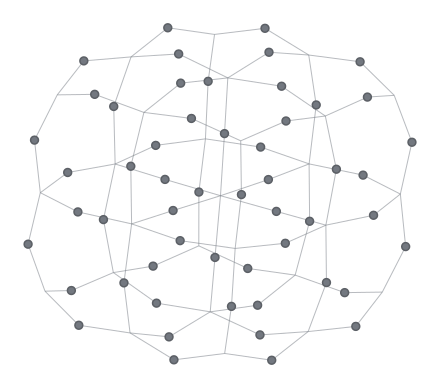

In [17]:
htn = qtn.HTN3D_classical_ising_partition_function(3, 3, 3, beta=0.22)
htn.draw()

Another way to visualize such hyperedges, using 'rubber bands', is provided by [`hypernetx`](https://github.com/pnnl/HyperNetX) - both the ``ind_map`` of a tensor network and the ``pos`` generate by ``draw`` are directly compatible:

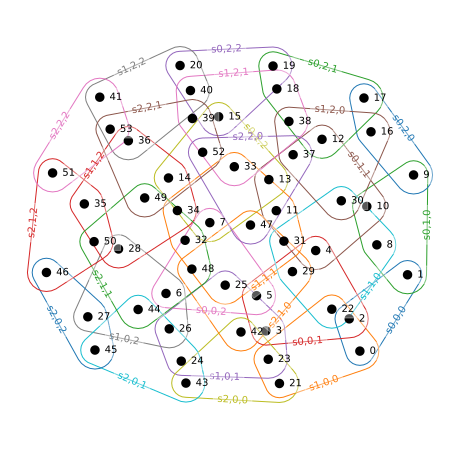

In [18]:
import hypernetx

H = hypernetx.Hypergraph(htn.ind_map)
hypernetx.draw(H, pos=htn.draw(get='pos'))

# Spanning trees

Various algorithms in ``quimb`` make use of a tree generated by spanning out from a particular region.

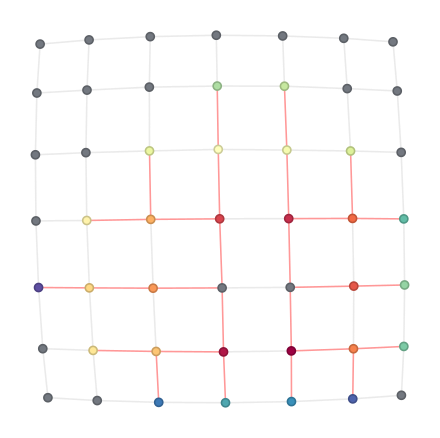

In [19]:
span_opts = {
    'max_distance': 3,
    'distance_sort': 'min',
    'ndim_sort': 'max',
}

qtn.TN2D_rand(7, 7, 3).draw_tree_span(
    tags=['I2,3', 'I2,2'],  which='any', **span_opts
)

# Interaction with ``matplotlib``

You can either add other stuff to the figure that ``quimb`` creates, or you can supply a ``matplotlib`` axis 
to add the tensor network drawing to directly.

The ``return_fig=True`` option allows you to modify the figure or save it to file:

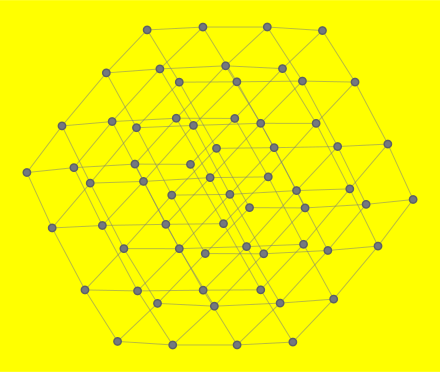

In [20]:
fig = tn.draw(return_fig=True)
fig.set_facecolor('yellow')

This could be saved with e.g.:
```python
fig.savefig('my-tn-drawing.png', bbox_inches='tight', dpi=300)
```

The ``ax=ax`` option allows you to add to an existing plot:

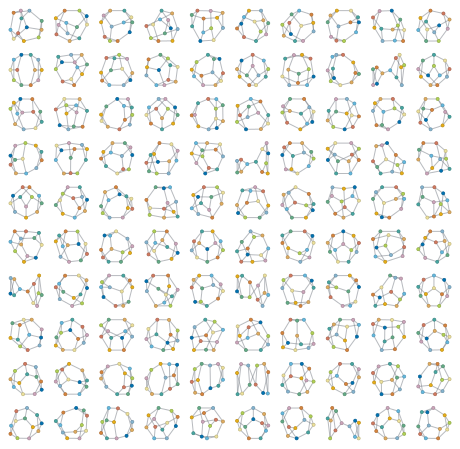

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10)

for ax in axs.flat:
    tn = qtn.TN_rand_reg(n=12, reg=3, D=2)
    tn.draw(tn.tags, ax=ax, legend=False, show_tags=False, node_size=10)
    ax.axis('off')

# 'Publication style' figures

There are some likely settings to tweak to generate neat 'publication style'
figures, but probably the most noticeable setting is explicitly laying out
the nodes with ``fix``.

Here we demonstrate drawing a PEPS with various options, in particular, 
embedding it in a 3D space so no edges are overlapping.

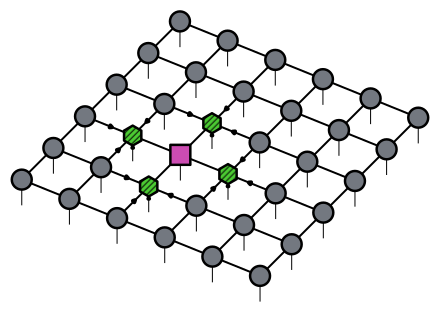

In [22]:
psi = qtn.PEPS.rand(6, 6, 4)

# fix the site tensors in one plane
fix = {
    psi.site_tag(i, j): get_3d_pos(i, j, 1)
    for i, j in psi.gen_site_coos()
}
# fix the site inidices in plane below
fix.update({
    psi.site_ind(i, j): get_3d_pos(i, j, 0.5)
    for i, j in psi.gen_site_coos()
})

# specific a tensor and its neighbors
tag0 = 'I2,2'
tags = ['I2,1', 'I1,2', 'I2,3', 'I3,2']

# create some arrows
psi.canonize_around_(tag0, max_distance=1)

# draw, with some manual style settings
psi.draw(
    color=(tag0, *tags),
    custom_colors=[(0.8, 0.3, 0.7)] + [(0.3, 0.8, 0.2)] * 4,
    fix=fix,
    edge_color='black',
    edge_alpha=1.0,
    edge_scale=1.0,
    arrow_overhang=1.0,
    arrow_linewidth=4,
    node_size=400,
    node_outline_darkness=0.0,
    node_outline_size=2.5,
    node_hatch={tag: '////' for tag in tags},
    node_shape={tag: 'h' for tag in tags} | {tag0: 's'},
    legend=False,
)